```
Copyright 2019 Augusto Cunha and Axelle Pochet

Permission is hereby granted, free of charge, to any person obtaining a copy of this code and 
associated documentation files, to deal in the code without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the code, and to permit persons to whom the code is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the code.

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT 
NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE.

__license__ = "MIT"
__author__ = "Augusto Cunha, Axelle Pochet"
__email__ = "acunha@tecgraf.puc-rio.br, axelle@tecgraf.puc-rio.br"
__credits__ = ["Augusto Cunha", "Axelle Pochet", "Helio Lopes", "Marcelo Gattass"]
```

# SFD-CNN-TL: Train final model and save

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['KERAS_BACKEND'] = 'tensorflow'

import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import classifier
import imageio
import metrics
# import tensorflow.python.keras.utils.vis_utils as graph
# import tensorflow.python.keras.utils.vis_utils as graph # new keras version
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian
from skimage import measure
from skimage import exposure
from sklearn.feature_extraction import image
from sklearn import svm
# import sklearn.external.joblib as extjoblib
# import joblib
# from sklearn.externals import joblib
from sklearn.utils import shuffle
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image, ImageDraw
from tensorflow.python.keras.models import Sequential, Model, model_from_json
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D # new keras version
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

np.random.seed(1337)

/home/anyu/anaconda3/envs/faultSeg36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anyu/anaconda3/envs/faultSeg36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anyu/anaconda3/envs/faultSeg36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anyu/anaconda3/envs/faultSeg36/lib

In [2]:
# adjust some settings for matplotlib for notebooks with black background
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 9
rcParams['text.color'] = 'white'
rcParams['axes.labelcolor'] = 'white'
rcParams['xtick.color'] = 'white'
rcParams['ytick.color'] = 'white'

In [3]:
# Enable interactive plots
#%matplotlib notebook

## Workflow
- Use our provided Syntectic dataset network weights
- Interpret one slice of the real data volume that will be classified
- Generate slice fault mask
- Train and save each analyzed method

## Define a seismic name

In [4]:
seismic_name = "gsb"

## Create colormap

In [5]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [1., 0., 0., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='faults',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

In [6]:
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [0., 0., 1., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='masks',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

## Set min values and steps

In [7]:
min_inl = 1565
step_inl = 2
min_crl = 2568
step_crl = 2
min_z = 1000
step_z = 4

## Generate mask image from fault points file
Our faults was exported from opendTect as ordered point set, witch points pair is one fault

In [8]:
sections = []

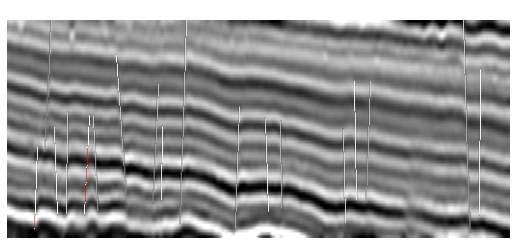

In [9]:
section_file = 'output/sections_regions/gsb/crl2600_sc_formatted_region_(1565.1000)(2531.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_crl_2600_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append(int(mask_data[i,6]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,2]-min_z)/step_z))

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 2600')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2600 = mask_img

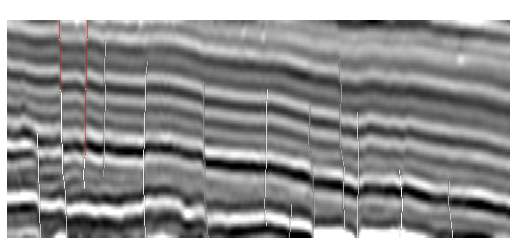

In [10]:
section_file = 'output/sections_regions/gsb/crl2800_sc_formatted_region_(1565.1000)(2531.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'mask_haibin_thin.png'
mask_img = cv2.imread(mask_file)
mask_img = mask_img[:,:,1]
mask_img = mask_img/255
lines_pair_points = []

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 2800')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2800 = mask_img

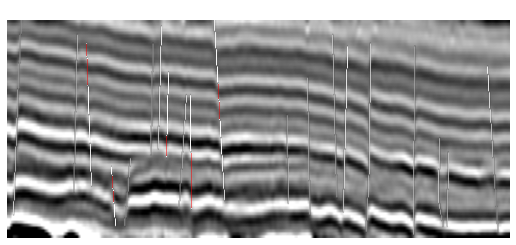

In [11]:
section_file = 'output/sections_regions/gsb/crl3000_sc_formatted_region_(1565.1000)(2531.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_crl_3000_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append((mask_data[i,6]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,2]-min_z)/step_z))

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 3000')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_3000 = mask_img

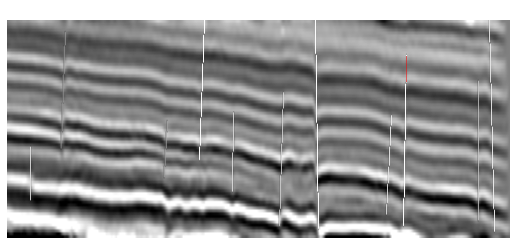

In [12]:
section_file = 'output/sections_regions/gsb/inl1791_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_inl_1791_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append(int(mask_data[i,7]-min_crl)/step_crl-3)
    lines_pair_points.append(int(mask_data[i,2]-min_z)/step_z)

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 1796')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_1796 = mask_img

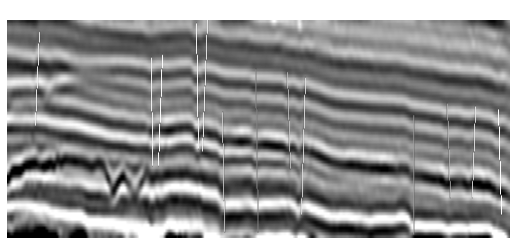

In [13]:
section_file = 'output/sections_regions/gsb/inl2011_sc_formatted_region_(2568.1000)(3568.1300).csv'
my_data = np.genfromtxt(section_file, delimiter=' ')
sections.append(my_data)
mask_file = 'data/gsb_inl_2011_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append(int(mask_data[i,7]-min_crl)/step_crl-3)
    lines_pair_points.append(int(mask_data[i,2]-min_z)/step_z)

im = Image.new('L', (my_data.shape[1], my_data.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section 2011')
plt.axis('off')
plt.imshow(my_data, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
#plt.imsave('mask.png', mask_img, cmap="gray")

mask_img_2011 = mask_img

## Generate patches from real slice

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

def generate_metrics(classesPredictionList, classesProbaPredictionList, y, verbose=True):
    """
    Metrics evaluate function:

    Compute all related metrics
    """
    # Count True Positive, True Negative, False Positive, False Negative
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in range( len(y) ):
        prediction = classesPredictionList[i]
        expected = y[i]
        if(prediction == expected):
            if(expected == 1): #Fault
                TP = TP + 1
            else: #NonFault
                TN = TN + 1
        else:
            if(expected == 1): #Fault
                FN = FN + 1
            else: #NonFault
                FP = FP + 1

    sensitivity = safe_div(TP , TP + FN)
    specificity = safe_div(TN , TN + FP) 
    accuracy = safe_div(TP + TN , TP + TN + FP + FN)
    precision = safe_div(TP , TP + FP)
    recall = sensitivity
    F1_score = safe_div(2 * (precision * recall) , precision + recall)
    
    if(verbose):
        print("METRICS:")
        print("Sensitivity:",sensitivity)
        print("Specificity:",specificity)
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",F1_score)
    
    ########### ROC, AUC #############
    # compute ROC, AUC
    fpr, tpr, thresholds = roc_curve(y, classesProbaPredictionList)
    AUC = auc(fpr, tpr)
    
    if(verbose):
        print("AUC:",AUC)
    
    return sensitivity, specificity, accuracy, precision, recall, F1_score, AUC

In [19]:
for i in range(len(sections)):
    print(sections[i].shape)

(76, 484)
(76, 484)
(76, 484)
(76, 498)
(76, 500)


In [20]:
model_name = "rcf_ft_96_1_shuffle_thick_9aug_smooth"

0
(76, 484)
4143
19272
section_patch_numbers 23415
(76, 484)
0.0
(76, 484)
(76, 484)
76 484
(23415,)
Accuracy: 0.8715
Sensitivity: 0.8294
Specificity: 0.8806
F1 Score: 0.6955
AUC: 0.9071
1
(76, 484)
2946
21895
section_patch_numbers 24841
(76, 484)
0.0
(76, 484)
(76, 484)
76 484
(24841,)


TypeError: 'numpy.float64' object is not callable

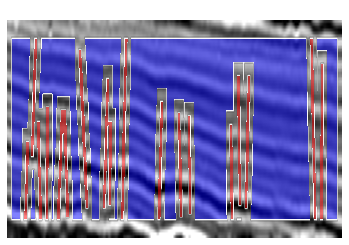

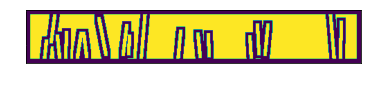

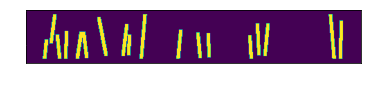

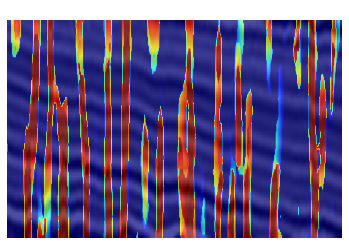

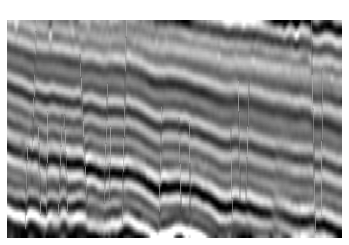

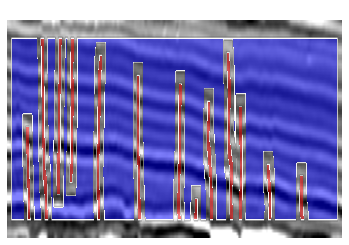

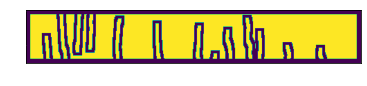

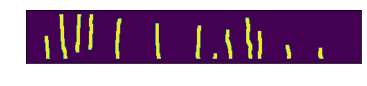

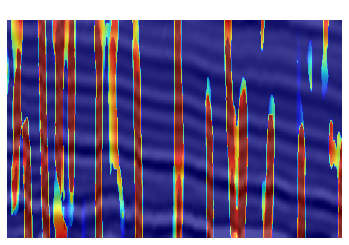

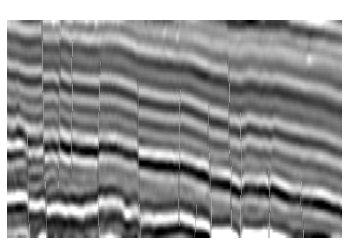

In [21]:
# Our method patch size
mask_size = 13
resize_size = 45
pixel_step = 1
imageChannels = 1

masks = [mask_img_2600,mask_img_2800,mask_img_3000,mask_img_1796,mask_img_2011]

#rezise_top, rezise_bottom, rezise_left, rezise_right = [int(mask_size/2)]*4
rezise_top, rezise_bottom, rezise_left, rezise_right = [0]*4
# print(rezise_top, rezise_bottom, rezise_left, rezise_right)

for sec_idx in range(len(sections)):
# for sec_idx in [4]:

    patches_fault = []
    patches_fault_name = []
    patches_non_fault = []
    patches_non_fault_name = []
    patches = []
    patches_name = []

    print(sec_idx)
    #reflected_section = cv2.copyMakeBorder(sections[sec_idx], rezise_top, rezise_bottom, rezise_left, rezise_right, cv2.BORDER_REFLECT)
    #reflected_mask = cv2.copyMakeBorder(masks[sec_idx], rezise_top, rezise_bottom, rezise_left, rezise_right, cv2.BORDER_CONSTANT,value=[0,0,0])
    reflected_section = sections[sec_idx]
    reflected_mask = masks[sec_idx]
    print(reflected_section.shape)
    
#     plt.figure(figsize=(9,4))
#     plt.title("model "+str(sec_idx))
#     plt.axis('off')
#     plt.imshow(reflected_section, cmap="gray", aspect='auto')
#     plt.imshow(reflected_mask, cmap="faults", aspect='auto')

    #patches_img = image.extract_patches_2d(reflected_section, (mask_size, mask_size))
    #patches_mask = image.extract_patches_2d(reflected_mask, (mask_size, mask_size))
    patches_img , patches_img_names = classifier.processPatches(reflected_section,  mask_size, pixel_step, resize_size, imageChannels)
    patches_mask , patches_mask_names = classifier.processPatches(reflected_mask,  mask_size, pixel_step, resize_size, imageChannels)
    patches = patches_img
    patches_name = patches_img_names
    
    for i in range(0, len(patches_mask)):
        if (patches_mask[i] == 0).sum() == patches_mask[i].size:
            patch = patches_img[i]
            patches_non_fault.append(patch)
            patches_non_fault_name.append(patches_img_names[i])
        elif (patches_mask[i][int(resize_size/2)-1:int(resize_size/2)+2,int(resize_size/2)-1:int(resize_size/2)+2]==0).sum() < 9:
#         elif patches_mask[i][int(resize_size/2),int(resize_size/2)] == 1:
            patch = patches_img[i]
            patches_fault.append(patch)
            patches_fault_name.append(patches_img_names[i])
            
    
    print(len(patches_fault))
    print(len(patches_non_fault))
    print("section_patch_numbers", len(patches_fault)+len(patches_non_fault))
#     section_patch_numbers.append(len(patches_fault)+len(patches_non_fault))
#     print("section_patch_numbers", section_patch_numbers)

    ## Reconstruct image from patches

    my_data = sections[sec_idx]
    print(my_data.shape)

    mask = np.zeros(my_data.shape)
    fault = np.zeros(my_data.shape)
    for patch_name in (patches_fault_name):
    #     print(patch_name)
        x = int(patch_name.split("_")[2])-rezise_left
        y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
        fault[x,y] = 1
    for patch_name in (patches_non_fault_name):
    #     print(patch_name)
        x = int(patch_name.split("_")[2])-rezise_left
        y = int(patch_name.split("_")[3].split(".")[0])-rezise_left
        mask[x,y] = 1

    plt.figure()
    plt.title("model")
    plt.axis('off')
    plt.imshow(my_data, cmap="gray", aspect='auto')
    plt.imshow(mask, cmap="masks", aspect='auto')
    plt.imshow(fault, cmap="faults", aspect='auto')

    eval_area = mask + fault
    plt.figure()
    plt.imshow(eval_area)
    print(eval_area[0][0])
    fault_area = fault
    nonfault_area = mask
    plt.figure()
    plt.imshow(fault_area)
    # plt.figure()
    # plt.imshow(nonfault_area)
#     section_eval_areas.append(eval_area)
#     section_fault_areas.append(fault_area)

    ourpred = np.load('./GSB_predictions/{}/{}.npy'.format(model_name,sec_idx))
    print(ourpred.shape)
    if sec_idx == 4:
        ourpred = ourpred[:,:500]

    plt.figure()
    plt.title("model")
    plt.axis('off')
    ax = plt.gca()
    plt.imshow(my_data, cmap="gray", aspect='auto')
    plt.imshow(ourpred, cmap="jet", aspect='auto', alpha=0.7)
    plt.savefig('./GSB_predictions/{}/{}_pred.png'.format(model_name,sec_idx))
    
    plt.figure()
    plt.title("model")
    plt.axis('off')
    ax = plt.gca()
    plt.imshow(my_data, cmap="gray", aspect='auto')
    plt.imshow(masks[sec_idx], cmap="faults", aspect='auto')

    print(my_data.shape)

    row,col = my_data.shape
    print(row,col)

    predlist = np.zeros(len(patches_fault)+len(patches_non_fault))
    print(predlist.shape)
    gtlist = np.zeros(len(patches_fault)+len(patches_non_fault))
    z = 0
    for i in range(row):
        for j in range(col):
            if eval_area[i][j]==1:
                predlist[z]=ourpred[i,j]
                gtlist[z]= 1 if fault_area[i,j]==1 else 0
                z = z+1


    sensitivity, specificity, accuracy, precision, recall, F1_score, auc = generate_metrics(predlist>0.5,predlist,gtlist,verbose=False)

    print("Accuracy: {:.4f}".format(accuracy))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))
    print("F1 Score: {:.4f}".format(F1_score))
    print("AUC: {:.4f}".format(auc))